In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import imageio
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.style.use("seaborn-dark")

import sys
sys.path.append("../")
from rl.agents.q_agent import QAgent

In [2]:
class Environment(object):
    
    def __init__(self, n_stops=8,method="angle_difference", **kwargs):
        
        print(f"Initialized Delivery Environment with {n_stops} random stops")
        print(f"Target metric for optimization is {method}")
              
        #Initializaiton 
        self.n_stops = n_stops
        self.action_space = self.n_stops
        self.observation_space = self.n_stops
        self.stops = []
        self.method = method
        
        
        #Generate Stops 
        self._generate_stops()
        self._generate_q_values()
        self.render
        self.reset()
        
        
    def _generate_stops(self):
        
        xy = np.loadtxt('test2.csv', delimiter=",")
        self.x = xy[:,0]
        self.y = xy[:,1]
        
    def _generate_q_values(self):
        xy = np.column_stack([self.x,self.y])
        mat =  np.zeros((len(xy), len(xy)))
        for i in range(len(xy)):
            for j in range(len(xy)):
                if (xy[j][1]-xy[i][1]) ==0:
                    mat[i][j] = -100
                elif (xy[j][1]!=0) and (xy[i][1]!=0):
                    mat[i][j] = -100
                else: 
                    mat[i][j] = (xy[j][0]-xy[i][0])/(xy[j][1]-xy[i][1])
        self.q_stops = mat
        
        # Normalize the matrix using Min-Max scaling
        mat_normalized = (mat - np.min(mat)) / (np.max(mat) - np.min(mat))

        self.q_stops = mat_normalized
        
    def render(self,return_img = False):
        
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        ax.set_title("Stops")

        # Show stops
        ax.scatter(self.x,self.y,c = "red",s = 50)

        # Show START
        if len(self.stops)>0:
            xy = self._get_xy(initial = True)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("START",xy=xy,xytext=xytext,weight = "bold")

        # Show itinerary
        if len(self.stops) > 1:
            ax.plot(self.x[self.stops],self.y[self.stops],c = "blue",linewidth=1,linestyle="--")
            
            # Annotate END
            xy = self._get_xy(initial = False)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("END",xy=xy,xytext=xytext,weight = "bold")

        plt.xticks([])
        plt.yticks([])
        
        if return_img:
            # From https://ndres.me/post/matplotlib-animated-gifs-easily/
            fig.canvas.draw_idle()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image
        else:
            plt.show()
    
    def reset(self):

        # Stops placeholder
        self.stops = [7]

        # Random first stop
        return self.stops[-1]

    def step(self,destination):

        # Get current state
        state = self._get_state()
        new_state = destination

        if self.q_stops[state, new_state] == -100:
            new_state = state
            
        # Get reward for such a move
        reward = self._get_reward(state,new_state)

        # Append new_state to stops
        self.stops.append(destination)
        done = len(self.stops) == self.n_stops

        return new_state,reward,done

    def _get_state(self):
        return self.stops[-1]


    def _get_xy(self,initial = False):
        state = self.stops[0] if initial else self._get_state()
        x = self.x[state]
        y = self.y[state]
        return x,y


    def _get_reward(self,state,new_state):
        base_reward = self.q_stops[state,new_state]
        return base_reward

def run_episode(env,agent,verbose = 1):

    s = env.reset()
    agent.reset_memory()

    max_step = env.n_stops
    
    episode_reward = 0
    
    # Remember the states
    agent.remember_state(s)
    # Take the action, and get the reward from environment
    s_next,r,done = env.step(0)

    # Tweak the reward
    r = r
    if verbose: print(s_next,r,done)

    # Update our knowledge ein the Q-table
    agent.train(s,0,r,s_next)

    # Update the caches
    episode_reward += r
    s = s_next
    
    i = 0
    while i < max_step-1:

        # Remember the states
        agent.remember_state(s)

        # Choose an action
        a = agent.act(s)
        
        # Take the action, and get the reward from environment
        s_next,r,done = env.step(a)

        # Tweak the reward
        r = r
        
        if verbose: print(s_next,r,done)
        
        # Update our knowledge in the Q-table
        agent.train(s,a,r,s_next)
        
        # Update the caches
        episode_reward += r
        s = s_next
        
        # If the episode is terminated
        i += 1
        if done:
            break
            
    return env,agent,episode_reward



class DeliveryQAgent(QAgent):

    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.reset_memory()

    def act(self,s):

        # Get Q Vector
        q = np.copy(self.Q[s,:])

        # Avoid already visited states
        q[self.states_memory] = -np.inf

        if np.random.rand() > self.epsilon:
            a = np.argmax(q)
        else:
            a = np.random.choice([x for x in range(self.actions_size) if x not in self.states_memory])

        return a


    def remember_state(self,s):
        self.states_memory.append(s)

    def reset_memory(self):
        self.states_memory = []



def run_n_episodes(env,agent,name="training.gif",n_episodes=1000,render_each=10,fps=10):

    # Store the rewards
    rewards = []
    imgs = []
    imgs2 = []

    # Experience replay
    for i in tqdm_notebook(range(n_episodes)):

        # Run the episode
        env,agent,episode_reward = run_episode(env,agent,verbose = 0)
        rewards.append(episode_reward)
            
        if i % render_each == 0:
            img = env.render(return_img = True)
            imgs.append(img)

    
    
    
    # Show rewards
    plt.figure(figsize = (15,3))
    plt.title("Rewards over training")
    plt.plot(rewards)
    plt.show()

    # Save imgs as gif
    imageio.mimsave(name,imgs,fps = fps)

    return env,agent

In [3]:
def run_corr_episode(env,agent,verbose = 1):

    s = env.reset()
    agent.reset_memory()
    arr = np.arange(1, 26)

    episode_reward = 0

    for i in arr:
                  
        # Remember the states
        agent.remember_state(s)
        
        # Take the action, and get the reward from environment
        s_next,r,done = env.step(i)

        # Tweak the reward
        r = r

        if verbose: print(s_next,r,done)

        # Update our knowledge ein the Q-table
        agent.train(s,i,r,s_next)

        # Update the caches
        episode_reward += r
        s = s_next

        # If the episode is terminated
        if done:
            break
            
    return env,agent,episode_reward

In [4]:
env = Environment()
print(env.q_stops)

Initialized Delivery Environment with 8 random stops
Target metric for optimization is angle_difference
[[0.         0.98382037 0.         0.98843461 0.         0.97235099
  0.         0.95932127 0.         0.96765428 0.         0.98650002
  0.         0.98719706 0.         0.96887097 0.         0.95928324
  0.         0.97113565 0.         0.98812029 0.         0.98485939
  0.         0.96545591]
 [0.98382037 0.         0.97249982 0.         0.97748993 0.
  0.992036   0.         0.9940688  0.         0.98082001 0.
  0.97201753 0.         0.97985957 0.         0.99359416 0.
  0.99261409 0.         0.97825689 0.         0.9722537  0.
  0.98274217 0.        ]
 [0.         0.97249982 0.         0.97565933 0.         0.96254676
  0.         0.94640772 0.         0.95716813 0.         0.97436613
  0.         0.97483656 0.         0.95862676 0.         0.94635658
  0.         0.96122447 0.         0.97545176 0.         0.97323553
  0.         0.95444132]
 [0.98843461 0.         0.97565933 0.

In [5]:
#Correct Reward Path For Light
env = Environment(n_stops = 26,method = "angle_difference" )
agent = DeliveryQAgent(env.observation_space,env.action_space)
env, agent, reward = run_corr_episode(env,agent)
print(reward)

Initialized Delivery Environment with 26 random stops
Target metric for optimization is angle_difference
1 0.0 False
2 0.9724998208302293 False
3 0.975659334033283 False
4 0.9812906843305169 False
5 0.9668684705329954 False
6 0.9794661845316461 False
7 0.9686929703318662 False
8 0.9710118222186326 False
9 0.9771473326448799 False
10 0.9648750645012931 False
11 0.9832840903622193 False
12 0.9738491878949818 False
13 0.9743099669685307 False
14 0.98287240367465 False
15 0.9652867511888624 False
16 0.9777154716629748 False
17 0.9704436832005376 False
18 0.9693245685069174 False
19 0.9788345863565949 False
20 0.9662648082615114 False
21 0.9818943466020009 False
22 0.9751763347021735 False
23 0.9729828201613389 False
24 0.9837523066184587 False
25 0.9644068482450537 True
23.377909858362145


In [6]:
env = Environment(n_stops = 26,method = "angle_difference" )

Initialized Delivery Environment with 26 random stops
Target metric for optimization is angle_difference


In [7]:
agent = DeliveryQAgent(env.observation_space,env.action_space)

C:\Users\PC\AppData\Local\Temp/ipykernel_12936/2996662991.py:221: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_episodes)):


  0%|          | 0/1000 [00:00<?, ?it/s]

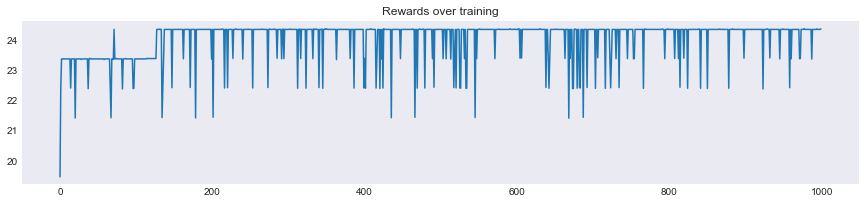

(<__main__.Environment at 0x22e04471bb0>,
 <__main__.DeliveryQAgent at 0x22e04420940>)

In [8]:
run_n_episodes(env,agent,"training_8_pts.gif")

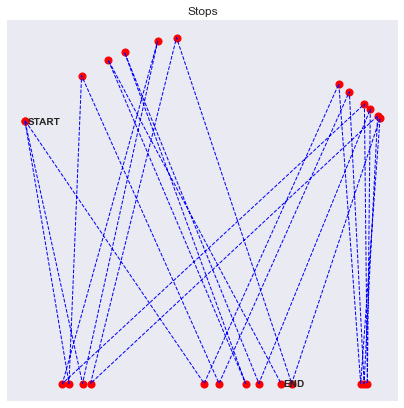

In [9]:
env.render()

Initialized Delivery Environment with 8 random stops
Target metric for optimization is angle_difference
Training with hyperparameters: {'epsilon': 0.2, 'epsilon_decay': 0.8, 'gamma': 0.7, 'lr': 0.1}


C:\Users\PC\AppData\Local\Temp/ipykernel_12936/2996662991.py:221: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_episodes)):


  0%|          | 0/1000 [00:00<?, ?it/s]

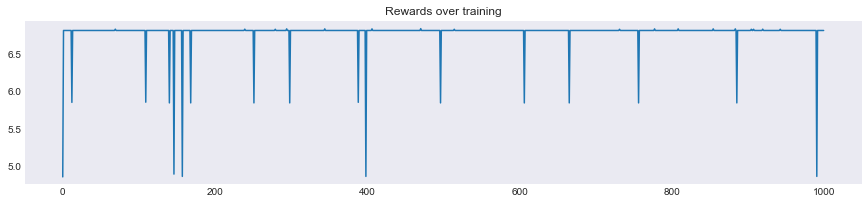

ValueError: not enough values to unpack (expected 3, got 2)

In [10]:
def grid_search_hyperparameters(env, hyperparameter_grid, n_episodes=1000, render_each=10, fps=10):
    best_hyperparameters = None
    best_mean_reward = float("-inf")
    rewards_by_hyperparameters = {}

    # Loop through all possible combinations of hyperparameters
    for hyperparameters in hyperparameter_grid:
        print(f"Training with hyperparameters: {hyperparameters}")

        # Create the agent with the current set of hyperparameters
        agent = DeliveryQAgent(states_size=env.observation_space, actions_size=env.action_space, 
                               epsilon=hyperparameters['epsilon'],
                               epsilon_decay=hyperparameters['epsilon_decay'],
                               gamma=hyperparameters['gamma'],
                               lr=hyperparameters['lr'])

        # Train the agent and get rewards
        _, _, rewards = run_n_episodes(env, agent, n_episodes=n_episodes, render_each=render_each, fps=fps)
        rewards_by_hyperparameters[str(hyperparameters)] = rewards

        # Calculate the mean reward over the last episodes
        mean_reward = np.mean(rewards[-100:])
        print(f"Mean reward over the last 100 episodes: {mean_reward}")

        # Check if it's the best set of hyperparameters so far
        if mean_reward > best_mean_reward:
            best_mean_reward = mean_reward
            best_hyperparameters = hyperparameters

    print("Grid search complete.")
    print("Best Hyperparameters:")
    print(best_hyperparameters)

    return best_hyperparameters, rewards_by_hyperparameters


if __name__ == "__main__":
    # Define the hyperparameter grid with the range of values to search through
    hyperparameter_grid = [
        {"epsilon": 0.2, "epsilon_decay": 0.8, "gamma": 0.7, "lr": 0.1},
        {"epsilon": 0.4, "epsilon_decay": 0.9, "gamma": 0.8, "lr": 0.3},
        {"epsilon": 0.6, "epsilon_decay": 0.95, "gamma": 0.9, "lr": 0.5},
        {"epsilon": 0.8, "epsilon_decay": 0.95, "gamma": 0.9, "lr": 0.7}
    ]

    # Create the environment
    env = Environment(n_stops=8)

    # Perform grid search hyperparameter tuning
    best_hyperparameters, rewards_by_hyperparameters = grid_search_hyperparameters(env, hyperparameter_grid)

    # Train the final agent with the best hyperparameters
    agent = DeliveryQAgent(states_size=env.observation_space, actions_size=env.action_space, 
                           epsilon=best_hyperparameters['epsilon'],
                           epsilon_decay=best_hyperparameters['epsilon_decay'],
                           gamma=best_hyperparameters['gamma'],
                           lr=best_hyperparameters['lr'])
    p, q, r = run_n_episodes(env, agent, n_episodes=5000, render_each=10, fps=10)
